# Supplemental Figure 5 E and F

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import pulp as p
from scipy import stats
import scipy as scipy
import matplotlib.patches as mpatches

In [2]:
#pip install pyppeteer

In [3]:
# don't print warning messages
import warnings
warnings.filterwarnings('ignore')

### Linear Programming Model 

In [4]:
def warburgModel(Glucose_Uptake_Rate, Y_Glyc, Y_Resp, V_Resp, V_Glyc, Mass_Fract_ATP, organism):
    
    '''The Warburg Model primary function is this publication. The function utilizes linear programming to 
    maximize the ATP production rate (mmol ATP per g cellular protein per hour) in the objective function 
    by assigning the functional fraction of fermentation and respiration in the ATP-producing proteome.
    
    The inputs into the model are:
    (1) glucose glucose uptake rate (mmol glucose per g cellular protein per hour)- Glucose_Uptake_Rate
    (2) ATP Yield per molecule of glucose for fermentation and respiation - Y_Glyc & Y_Resp
    (3) Specific activity of fermentation and respiation (mmol per g pathway protein per hr) - V_Resp & V_Glyc
    (4) Fraction of the proteome for ATP-producing enzymes - Mass_Fract_ATP
    
    The outputs of the function are:
    (1) Functional proteome occupancy of fermentation and respiration -  Mass_Fract_Glyc & Mass_Fract_Resp
    (2) Maximal ATP production rate - ATP production rate (mmol per g cellular protein per hour)
    (3) Rate of fermentation and respiration that produce the maximal ATP production rate - Lact_rate & Resp_rate (mmol per g cellular protein per hour)'''

    # Create a LP Maximization problem
    warburg_prob = p.LpProblem('Problem', p.LpMaximize) 
  
    # Create problem Variables 
    Mass_Fract_Glyc = p.LpVariable("Mass_Fract_Glyc", lowBound = 0, upBound = 1, cat='Continuous') 
    Mass_Fract_Resp = p.LpVariable("Mass_Fract_Resp", lowBound = 0, upBound = 1, cat='Continuous')   
  
    # Objective Function
    warburg_prob += Y_Glyc * V_Glyc * Mass_Fract_Glyc + Y_Resp * V_Resp * Mass_Fract_Resp 
  
    # Constraints:

    warburg_prob += V_Glyc * Mass_Fract_Glyc + V_Resp * Mass_Fract_Resp <= Glucose_Uptake_Rate
    warburg_prob += Mass_Fract_Glyc + Mass_Fract_Resp <= Mass_Fract_ATP
  
    status = warburg_prob.solve()   # Solver
    #print(p.LpStatus[status])   # The solution status
    
    if organism == 'ecoli': 
        
        #Calculation of Acetate Production and Oxygen Consumption Rates
        #Note the a seperate calculation in in necessary for E. coli since Acetate Respiration Consumes Oxygen
        Lact_rate = 2 * p.value(Mass_Fract_Glyc) * V_Glyc
        Resp_rate = 6 * p.value(Mass_Fract_Resp) * V_Resp + p.value(Mass_Fract_Glyc) * 2 * V_Glyc
    
    else:  
        
        #Calculation of Ethanol/Lactate Production and Oxygen Consumption Rates
        Lact_rate = 2 * p.value(Mass_Fract_Glyc) * V_Glyc
        Resp_rate = 6 * p.value(Mass_Fract_Resp) * V_Resp
  
    # Printing the final solution
    return(p.value(Mass_Fract_Glyc), p.value(Mass_Fract_Resp), p.value(warburg_prob.objective), Lact_rate, Resp_rate)  

### Bootstrapping Model

In [5]:
def waburgLoop(rates, proteomics, ferm_proteomics, resp_proteomics, gly_proteomics, Y_Glyc, Y_Resp, min_gluc, max_gluc, organism): 
    
    '''Performs bootstrapping to resample the five parameter estimates (i.e. fraction of 
    the proteome occupied by pathway, specific activity, and ATP yield) with replacement (N=10,000). 
    After each round of sampling, the specific activity of each pathway is calculated. The sampled 
    parameter values for proteome occupied by pathway, specific activity, and ATP yield from each 
    round of bootstrapping are used in the linear program described in the function above. 
    All 10,000 results are stored in a data frame, which in the output.'''

    results_final = []
    
    for j in tqdm(range(10000)):
        V_Resp = []
        V_Glyc = []
        Mass_Fract_ATP = []
    
        #random choice with replacement for each paramter 
        sample_activity_respiration = rates.loc[rates['pathway'] == 'Respiration', 'glucose uptake rate  (mmol gprotein-1 hr-1)'].unique() / 60
        #print(sample_activity_respiration)
        sample_activity_fermentation = rates.loc[rates['pathway'] == 'Fermentation', 'glucose uptake rate  (mmol gprotein-1 hr-1)'].unique() / 60
        #print(sample_activity_fermentation)
        sample_mass_respiraition = resp_proteomics.loc[(resp_proteomics['estimate'] == 'respiration'), 'value'].unique()
        #print(sample_mass_respiraition)
        sample_mass_fermentation = ferm_proteomics.loc[(ferm_proteomics['estimate'] == 'fermentation'), 'value'].unique()
        #print(sample_mass_fermentation)
        sample_mass_ATP = proteomics['value'].unique()
        sample_mass_glycolysis = gly_proteomics.loc[(gly_proteomics['estimate'] == 'fermentation'), 'value'].unique()
        
        sample_size_activity_respiration = len(sample_activity_respiration)
        sample_size_activity_fermentation = len(sample_activity_fermentation)
        sample_size_mass_respiraition = len(sample_mass_respiraition)
        sample_size_mass_fermentation = len(sample_mass_fermentation)
        sample_size_mass_ATP = len(sample_mass_ATP)
        sample_size_mass_glycolysis= len(sample_mass_glycolysis)
    
        sample_specific_activity_fermentation = np.random.choice(sample_activity_fermentation, size=sample_size_activity_fermentation,replace=True)
        sample_specific_activity_respiration = np.random.choice(sample_activity_respiration, size=sample_size_activity_respiration, replace=True)
        sample_fraction_fermentation = np.random.choice(sample_mass_fermentation, size=sample_size_mass_fermentation, replace=True)
        sample_fraction_respiration = np.random.choice(sample_mass_respiraition, size=sample_size_mass_respiraition, replace=True)
        sample_fraction_ATP = np.random.choice(sample_mass_ATP, size=sample_size_mass_ATP, replace=True)
        sample_fraction_glycolysis = np.random.choice(sample_mass_glycolysis, size=sample_size_mass_glycolysis, replace=True)
        
        #calculate model parameters for current bootstrap iteration   
        V_Resp =  sample_specific_activity_respiration.mean() / sample_fraction_respiration.mean() 
        #print(V_Resp)
        V_Glyc = sample_specific_activity_fermentation.mean() / sample_fraction_fermentation.mean() 
        #print(V_Glyc)
        #print(sample_specific_activity_fermentation.mean())
        
        V_Glyc_2 = sample_specific_activity_fermentation.mean() / sample_fraction_glycolysis.mean() 
        
        rate_ratio = V_Resp / V_Glyc_2
        
        V_Resp =  sample_specific_activity_respiration.mean() / (sample_fraction_respiration.mean() + sample_fraction_glycolysis.mean() * rate_ratio)

        #print(V_Glyc)
        #print(V_Resp)
        
        Mass_Fract_ATP = sample_fraction_ATP.mean() 
        #print(Mass_Fract_ATP)
        Y_Glyc = Y_Glyc
        Y_Resp = Y_Resp
        
        #glucose uptake rates to loop through 
        gluc = np.linspace(min_gluc, max_gluc, 200)
        
        #Empty arrays to save results
        glucose_uptake = []
        glyc_mass = []
        resp_mass = []
        atp = []
        lact = []
        o2 = []
    
        #loop through the linear model for each glucose uptake rate
        for i in range(len(gluc)):
            loop_result = (warburgModel(gluc[i], Y_Glyc, Y_Resp, V_Resp, V_Glyc, Mass_Fract_ATP, organism)) 
            #print(loop_result)
            
            glyc_mass.append(loop_result[0])
            resp_mass.append(loop_result[1])
            atp.append(loop_result[2])
            lact.append(loop_result[3])
            o2.append(loop_result[4])
            glucose_uptake.append(gluc[i])
            
        results = [glyc_mass, resp_mass, atp, lact, o2, glucose_uptake]
        
        #Append the outputs for each bootstrap iteration
        results_final.append(results)
    
    #Convert the array into a dataframe
    df = pd.DataFrame({'gluc' : [], 'glyc_mass' : [], 'resp_mass' : [], 'atp' : [], 'lact' : [], 'o2' : []})

    for i in range(len(results_final)):
        df_temp_gluc = pd.DataFrame({'gluc' : results_final[i][5]})
        df_temp_gly = pd.DataFrame({'glyc_mass' : results_final[i][0]})
        df_temp_resp = pd.DataFrame({'resp_mass' : results_final[i][1]})
        df_temp_atp = pd.DataFrame({'atp' : results_final[i][2]})
        df_temp_lac = pd.DataFrame({'lact' : results_final[i][3]})
        df_temp_o2 = pd.DataFrame({'o2' : results_final[i][4]})
        out = df_temp_gluc.join([df_temp_gly, df_temp_resp, df_temp_atp, df_temp_lac, df_temp_o2])
        
        df = pd.concat([df, out])
        
    return(df)

In [6]:
def waburgCI(df): 
    
    '''Calculates the 95 confidence interval for each output of the model'''

    df_sub = df[['glyc_mass', 'resp_mass', 'atp', 'lact', 'o2']]

    df_95_low = pd.DataFrame(np.array(df['gluc'].unique()), columns=['gluc'])
    df_95_high = pd.DataFrame(np.array(df['gluc'].unique()), columns=['gluc'])

    for column in list(df_sub.columns): 
        df_temp = df_sub[[column]]
        df_temp = pd.concat([df[['gluc']],df_temp],axis=1)
        #print(df_temp)
        column_names = ['gluc', column]
        df_95_temp_low = pd.DataFrame(columns = column_names)
        df_95_temp_high = pd.DataFrame(columns = column_names)
        for gluc_uptake in list(df_temp['gluc'].unique()):
        #print(gluc_uptake)
            sample = np.array(df_temp.loc[df_temp['gluc'] == gluc_uptake, column])
            #mean, sigma = np.mean(sample), np.std(sample)
            #conf_int = stats.norm.interval(0.95, loc=mean, scale=sigma)
            #confidence95 = mean - conf_int[0]
            sample_count = len(sample)
            sample_high = sample_count * .975
            sample_low = sample_count * .025
            sample = np.sort(sample)
            conf95_high = sample[int(sample_high) - 1]
            conf95_low = sample[int(sample_low) - 1]
            data_low = {'gluc': [gluc_uptake], column: [conf95_low]}
            data_high = {'gluc': [gluc_uptake], column: [conf95_high]}
            data_low_df = pd.DataFrame(data_low)
            data_high_df = pd.DataFrame(data_high)
            df_95_temp_low = df_95_temp_low.append(data_low_df)
            df_95_temp_high = df_95_temp_high.append(data_high_df)
        df_95_low = df_95_low.merge(df_95_temp_low, on='gluc')
        df_95_high = df_95_high.merge(df_95_temp_high, on='gluc')
    df_95 = pd.merge(df_95_low, df_95_high, on = 'gluc', how = 'left')
    
    return(df_95)    

## Model Estimates for *S. cerevisiae*: Fig S5 E

In [7]:
#parameter estimates for proteome occupany
proteomics = pd.read_csv('./Data/yeast_proteomics_sum_total_full_mito.csv')

#parameters estimates for specfic activity
rates = pd.read_csv('./Data/yeast_cellular_rates.csv')

#parameters estimates for specfic activity proteome
resp_proteomics = pd.read_csv('./Data/yeast_specific_activity_resp_occupancy_full_mito.csv')
ferm_proteomics = pd.read_csv('./Data/yeast_specific_activity_ferm_occupancy.csv')

In [8]:
#data into waburgLoop function 
yeast_model = waburgLoop(rates, proteomics, ferm_proteomics, resp_proteomics, ferm_proteomics, 2, 16, 0.1/60, 39/60, 'yeast')

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
#calculate confidence interval 
yeast_model_conf = waburgCI(yeast_model)

In [10]:
#reset index
yeast_model_mean = yeast_model.groupby('gluc').median().reset_index()

In [11]:
#experimental values (points on figs below) to compare to model predictions
yeast_experiments = pd.read_csv('./Data/yeast_experimental.csv')

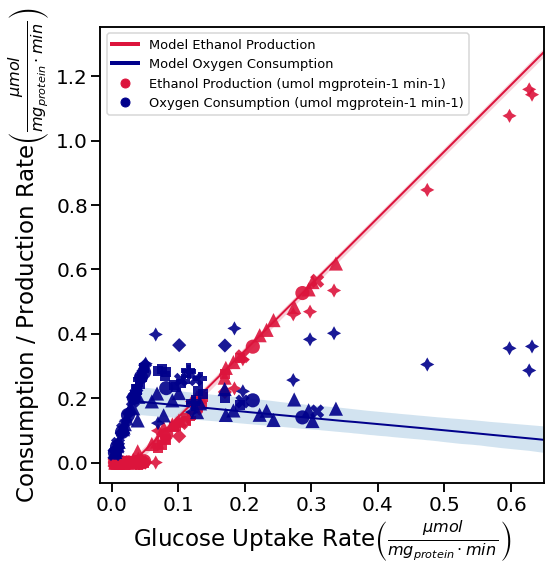

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.patch.set_facecolor('white')
sns.set_context("talk")


#plot model predictions 
ax.plot(yeast_model_mean['gluc'], yeast_model_mean['lact'], color = 'crimson', linewidth = 2, label='Model Ethanol Production')
ax.fill_between(yeast_model_mean['gluc'], yeast_model_conf['lact_y'], yeast_model_conf['lact_x'], color = 'crimson', alpha=0.2, linewidth = 0)
ax.plot(yeast_model_mean['gluc'], yeast_model_mean['o2'], color = 'darkblue', linewidth = 2, label='Model Oxygen Consumption')
ax.fill_between(yeast_model_mean['gluc'],yeast_model_conf['o2_y'], yeast_model_conf['o2_x'], alpha=0.2, linewidth = 0)

#plot experimental data
sns.scatterplot(yeast_experiments['Glucose Consumption (mmol gprotein-1 hr-1)']/60, yeast_experiments['Ethanol Production (mmol gprotein-1 hr-1)']/60, color = 'crimson', alpha=.9, label='Experimental Ethanol Production', linewidth = 0, s=200, zorder = 3, style = yeast_experiments['Author'])
sns.scatterplot(yeast_experiments['Glucose Consumption (mmol gprotein-1 hr-1)']/60, yeast_experiments['Oxygen Consumption (mmol gprotein-1 hr-1)']/60, color = 'darkblue', alpha=.9, label='Experimental Oxygen Consumption', linewidth = 0, s=200, zorder = 4, style = yeast_experiments['Author'])

#axis format
ax.set_xlabel("Glucose Uptake Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=23)
ax.set_ylabel("Consumption / Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlim(-1/60, yeast_model_conf['gluc'].max())

#legend format 
custom = [Line2D([0], [0], color='crimson', lw=4),
          Line2D([0], [0], color='darkblue', lw=4),
          Line2D([], [], marker='o', color='crimson', linestyle='None'),
          Line2D([], [], marker='o', color='darkblue', linestyle='None')]
plt.legend(custom, ['Model Ethanol Production', 'Model Oxygen Consumption', 'Ethanol Production (umol mgprotein-1 min-1)', 'Oxygen Consumption (umol mgprotein-1 min-1)'], fontsize = 13, loc='upper left')


plt.tight_layout()


In [16]:
#save figure
fig.savefig('sf5e_yeast_full_mito.svg',format='svg', dpi=1200)

## Model Estimates for Mammalian cells: Fig S5 F

In [17]:
#parameter estimates for proteome occupany
proteomics = pd.read_csv('./Data/mammalian_proteomics_sum_full_mito.csv')

#parameters estimates for specfic activity
rate = pd.read_csv('./Data/mammalian_cellular_rates.csv')

#parameters estimates for specfic activity proteome
resp_proteomics = pd.read_csv('./Data/mammalian_specific_activity_resp_occupancy_full_mito.csv')
ferm_proteomics = pd.read_csv('./Data/mammalian_specific_activity_ferm_occupancy.csv')

In [18]:
#data into waburgLoop function
mammalian_model = waburgLoop(rate, proteomics, ferm_proteomics, resp_proteomics, ferm_proteomics, 2, 29, 0.01/60, 1/60, 'human')

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
#calculate confidence interval 
mammalian_model_conf = waburgCI(mammalian_model)

In [20]:
#reset index
mammalian_model_mean = mammalian_model.groupby('gluc').median().reset_index()

In [21]:
#experimental values (points on figs below) to compare to model predictions
mammalian_experiments = pd.read_csv('./Data/mammalian_experimental.csv')

### Fig. 3c

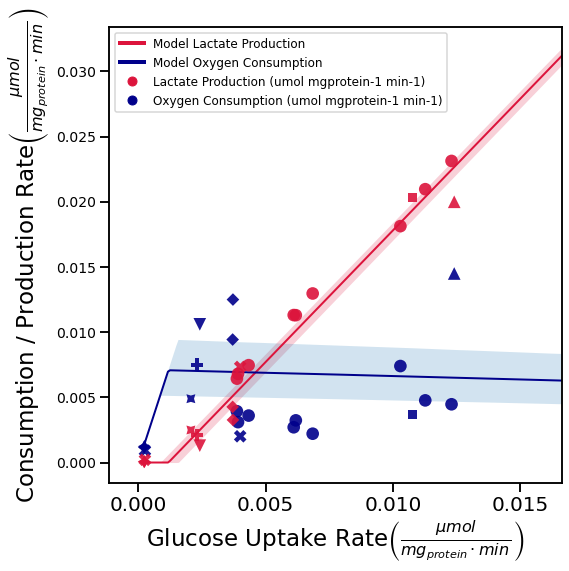

In [22]:
fig, ax = plt.subplots(figsize=(8.25,8))
ax.patch.set_facecolor('white')
sns.set_context("talk")

#plot model predictions 
ax.plot(mammalian_model_mean['gluc'], mammalian_model_mean['lact'], color = 'crimson', linewidth = 2, label='Model Lactate Production', zorder = 1)
ax.fill_between(mammalian_model_mean['gluc'], mammalian_model_conf['lact_y'], mammalian_model_conf['lact_x'], color = 'crimson', alpha=0.2, linewidth = 0)
ax.plot(mammalian_model_mean['gluc'], mammalian_model_mean['o2'], color = 'darkblue', linewidth = 2, label='Model Oxygen Consumption', zorder = 2)
ax.fill_between(mammalian_model_mean['gluc'], mammalian_model_conf['o2_y'], mammalian_model_conf['o2_x'], alpha=0.2, linewidth = 0)

#plot experimental data
sns.scatterplot(mammalian_experiments['Glucose Consumption (mmol gprotein-1 hr-1)']/60, mammalian_experiments['Lactate Production (mmol gprotein-1 hr-1)']/60, color = 'crimson', alpha=.9, label='Experimental Lactate Production', linewidth = 0, s=160, zorder = 4, style = mammalian_experiments['Author'])
sns.scatterplot(mammalian_experiments['Glucose Consumption (mmol gprotein-1 hr-1)']/60, mammalian_experiments['Oxygen Consumption (mmol gprotein-1 hr-1)']/60, color = 'darkblue', alpha=.9, label='Experimental Oxygen Consumption', linewidth = 0, s=160, zorder =3, style = mammalian_experiments['Author'])

#axis format
ax.set_xlabel("Glucose Uptake Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=23)
ax.set_ylabel("Consumption / Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=23)
ax.tick_params(axis='y', which='major', labelsize=14)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.set_xlim(-.07/60, mammalian_model_conf['gluc'].max())

#legend format 
custom = [Line2D([0], [0], color='crimson', lw=4),
          Line2D([0], [0], color='darkblue', lw=4),
          Line2D([], [], marker='o', color='crimson', linestyle='None'),
          Line2D([], [], marker='o', color='darkblue', linestyle='None')]
plt.legend(custom, ['Model Lactate Production', 'Model Oxygen Consumption', 'Lactate Production (umol mgprotein-1 min-1)', 'Oxygen Consumption (umol mgprotein-1 min-1)'], fontsize = 12, loc='upper left')

plt.tight_layout()

In [24]:
#save figure
fig.savefig('./Figures/sf5f_mammlian_full_mito.svg',format='svg', dpi=1200)